In [1]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import DBSCAN
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import Birch
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from scipy import ndimage
from sklearn import manifold
from sklearn import metrics
import pandas as pd
from time import time

In [2]:
digits = load_digits() 
X = digits.data
y = digits.target

In [3]:
np.random.seed(0)

In [4]:
X = manifold.SpectralEmbedding(n_components=2).fit_transform(X)

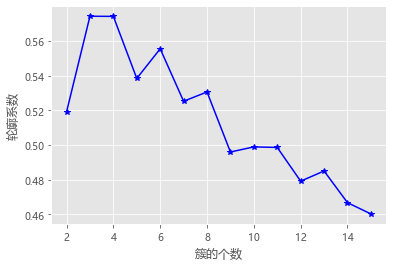

In [5]:
# 构造自定义函数，用于绘制不同k值和对应轮廓系数的折线图
def k_silhouette(X, clusters):
    K = range(2,clusters+1)
    # 构建空列表，用于存储个中簇数下的轮廓系数
    S = []
    for k in K:
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X)
        labels = kmeans.labels_
        # 调用字模块metrics中的silhouette_score函数，计算轮廓系数
        S.append(metrics.silhouette_score(X, labels, metric='euclidean'))

    # 中文和负号的正常显示
    plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
    plt.rcParams['axes.unicode_minus'] = False
    # 设置绘图风格
    plt.style.use('ggplot')    
    # 绘制K的个数与轮廓系数的关系
    plt.plot(K, S, 'b*-')
    plt.xlabel('簇的个数')
    plt.ylabel('轮廓系数')
    # 显示图形
    plt.show()
    
# 自定义函数的调用
k_silhouette(X, 15)

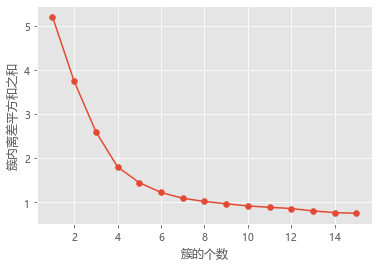

In [6]:
distance = []
k = []
#簇的数量
for n_clusters in range(1,16):
    cls = KMeans(n_clusters).fit(X)

    #曼哈顿距离
    def manhattan_distance(x,y):
        return np.sum(abs(x-y))

    distance_sum = 0
    for i in range(n_clusters):
        group = cls.labels_ == i
        members = X[group,:]
        for v in members:
            distance_sum += manhattan_distance(np.array(v), cls.cluster_centers_[i])
    distance.append(distance_sum)
    k.append(n_clusters)
plt.scatter(k, distance)
plt.plot(k, distance)
plt.xlabel("簇的个数")
plt.ylabel("簇内离差平方和之和")
plt.show()

KMeans:	0.04s


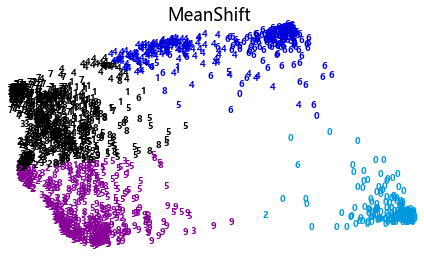

In [18]:
t0 = time()
kmeans = KMeans(n_clusters = 4)
kmeans.fit(X)
digits['kmeans_label'] = kmeans.labels_
print("KMeans:\t%.2fs" % (time() - t0))
plot_clustering(X, kmeans.labels_,"KMeans" )

In [8]:
res = []
for eps in np.arange(0.0004,0.001,0.0001):
    for min_samples in range(100,160):
        dbscan = DBSCAN(eps = eps, min_samples = min_samples)
        dbscan.fit(X)
        n_clusters = len([i for i in set(dbscan.labels_) if i != -1])
        outliners = np.sum(np.where(dbscan.labels_ == -1, 1,0))
        stats = str(pd.Series([i for i in dbscan.labels_ if i != -1]).value_counts().values)
        res.append({'eps':eps,'min_samples':min_samples,'n_clusters':n_clusters,'outliners':outliners,'stats':stats})
       
df = pd.DataFrame(res)
df
df.loc[df.outliners<30, :]

,eps,min_samples,n_clusters,outliners,stats
240,0.0008,100,2,18,[1610 169]
241,0.0008,101,2,18,[1610 169]
242,0.0008,102,2,18,[1610 169]
243,0.0008,103,2,18,[1610 169]
244,0.0008,104,2,18,[1610 169]
...,...,...,...,...,...
355,0.0009,155,4,19,[1297 223 169 89]
356,0.0009,156,4,20,[1297 220 168 92]
357,0.0009,157,4,21,[1297 219 168 92]
358,0.0009,158,4,21,[1297 219 168 92]


DBSCAN:	0.02s


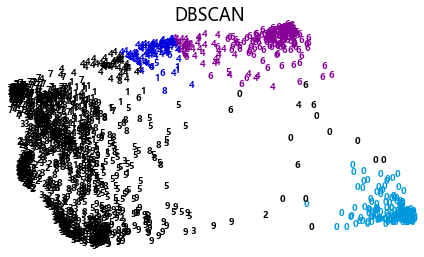

In [19]:
t1 = time()
dbscan = DBSCAN(eps = 0.0009, min_samples = 156)
dbscan.fit(X)
digits['dbscan_label'] = dbscan.labels_
print("DBSCAN:\t%.2fs" % (time() - t1))
plot_clustering(X, dbscan.labels_,"DBSCAN" )

In [11]:
def plot_clustering(X_red, labels, title=None):
    x_min, x_max = np.min(X_red, axis=0), np.max(X_red, axis=0)
    X_red = (X_red - x_min) / (x_max - x_min)

    plt.figure(figsize=(6, 4))
    for i in range(X_red.shape[0]):
        plt.text(X_red[i, 0], X_red[i, 1], str(y[i]),
                 color=plt.cm.nipy_spectral(labels[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    plt.xticks([])
    plt.yticks([])
    if title is not None:
        plt.title(title, size=17)
    plt.axis('off')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

MeanShift:	0.15s


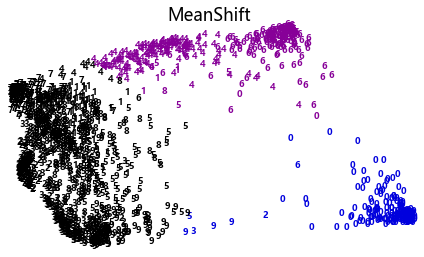

In [12]:
t3 = time()
bandwidth = estimate_bandwidth(X)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
print("MeanShift:\t%.2fs" % (time() - t3))
plot_clustering(X, ms.labels_,"MeanShift" )

 Birch:	0.07s


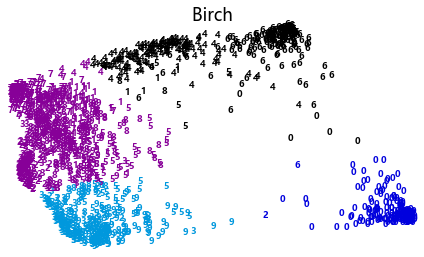

In [14]:
t4 = time()
birch = Birch(threshold = 0.001,n_clusters = 4)
birch.fit_predict(X)
print(" Birch:\t%.2fs" % (time() - t4))
plot_clustering(X, birch.labels_," Birch" )

ward :	0.06s
average :	0.06s
complete :	0.06s
single :	0.02s


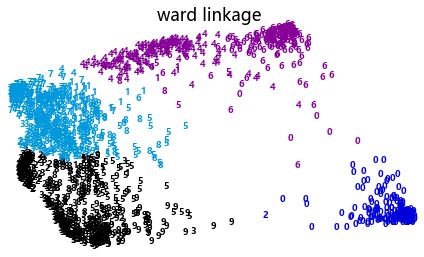

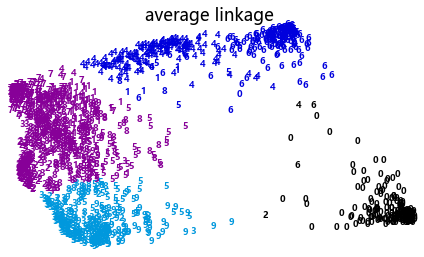

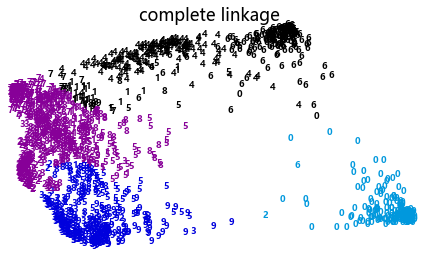

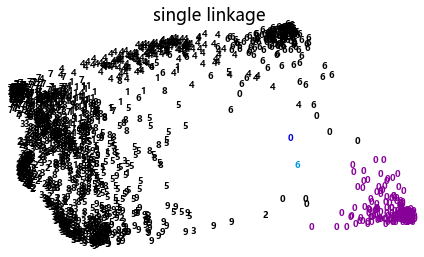

In [17]:
for linkage in ('ward', 'average', 'complete', 'single'):
    clustering = AgglomerativeClustering(linkage=linkage, n_clusters=4)
    t5 = time()
    clustering.fit(X)
    print("%s :\t%.2fs" % (linkage, time() - t5))

    plot_clustering(X, clustering.labels_, "%s linkage" % linkage)


plt.show()